In [1]:
# data loading error fix by google search
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [3]:
import tensorflow_datasets as tfds

In [4]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiab

### Load Data

- big size data
- use only validation and test data
- resize the img

In [5]:
celeb_a = tfds.load('celeb_a')

In [6]:
import imageio
from skimage.transform import resize

In [7]:
celeb_a_train, celeb_a_test = celeb_a['validation'], celeb_a['test']

In [8]:
train_images = []
train_labels = []

for tensor in tfds.as_numpy(celeb_a_train):
    isMale = tensor['attributes']['Male']
    isSmiling = tensor['attributes']['Smiling']
    
    label = np.array([isMale, isSmiling]).astype(np.int8)
    img = resize(tensor['image'], (72, 59))
    
    train_images.append(img)
    train_labels.append(label)

In [9]:
test_images = []
test_labels = []

for tensor in tfds.as_numpy(celeb_a_test):
    isMale = tensor['attributes']['Male']
    isSmiling = tensor['attributes']['Smiling']
    
    label = np.array([isMale, isSmiling]).astype(np.int8)
    img = resize(tensor['image'], (72, 59))
    
    test_images.append(img)
    test_labels.append(label)

In [10]:
len(test_images), len(train_images)

(19962, 19867)

In [11]:
m_s = [] # male smile
f_s = [] # female smile
m_n = [] # male not smile
f_n = [] # female not smile

for a, b in zip(test_images, test_labels):
    if b[0] and b[1]:
        m_s.append((a,b))
    elif not b[0] and b[1]:
        f_s.append((a,b))
    elif b[0] and not b[1]:
        m_n.append((a,b))
    elif not b[0] and not b[0]:
        f_n.append((a,b))

In [12]:
len(m_s), len(f_s), len(m_n), len(f_n)

(3094, 6893, 4621, 5354)

In [13]:
total = m_s[:550] + f_s[:550] + m_n[:550] + f_n[:550]

In [14]:
len(total)

2200

In [15]:
import random
random.shuffle(total)
trains = total[:2000]
tests = total[2000:]
len(trains), len(tests)

(2000, 200)

In [16]:
train_images, train_labels = list(zip(*trains))
test_images, test_labels = list(zip(*tests))

train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [17]:
x = train_images[0]
y = train_labels[0]
print(x.shape, y.shape)

(72, 59, 3) (2,)


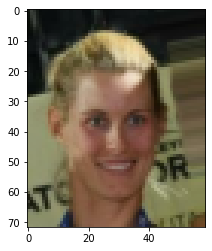

[0 1]


In [18]:
plt.imshow(x)
plt.show()
print(y)

In [19]:
print(train_images.shape, test_images.shape) # check shape
print(train_labels.shape, test_labels.shape) # check shape

print(train_images.dtype, test_images.dtype) # check data type
print(train_labels.dtype, test_labels.dtype) # check data type

(2000, 72, 59, 3) (200, 72, 59, 3)
(2000, 2) (200, 2)
float64 float64
int8 int8


In [20]:
# find min/max of image data
print(train_images.min(), train_images.max())
print(test_images.min(), test_images.max())

0.0 1.0
0.0 1.0


### one-hot encoding 
- (male/female, smile/not smile) -> (male, female, smile, not smile)
    - i.e. (0, 0) -> (1, 0, 1, 0)
    - i.e. which means female not smiling

In [21]:
from tensorflow.keras.utils import to_categorical

train_male_labels, train_smile_labels = np.split(train_labels, 2, axis = 1)
test_male_labels, test_smile_labels = np.split(test_labels, 2, axis = 1)

[0] [1]


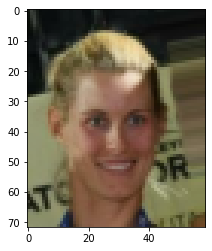

In [22]:
print(train_male_labels[0], train_smile_labels[0]) # 1/0: male/female, 1/0: smile/not smile
plt.imshow(train_images[0])
plt.show()

In [23]:
train_male_labels = to_categorical(train_male_labels, dtype='int8')
train_smile_labels = to_categorical(train_smile_labels, dtype='int8')
test_male_labels = to_categorical(test_male_labels, dtype='int8')
test_smile_labels = to_categorical(test_smile_labels, dtype='int8')

In [24]:
print(train_male_labels.shape, train_smile_labels.shape)

(2000, 2) (2000, 2)


In [25]:
train_labels2 = np.concatenate([train_male_labels, train_smile_labels], axis=1)
test_labels2 = np.concatenate([test_male_labels, test_smile_labels], axis=1)

In [26]:
print(train_labels2.shape, test_labels2.shape)

(2000, 4) (200, 4)


### Visualization

In [27]:
visual = train_images[:5]
visual = np.hstack(visual)
print(visual.shape)

(72, 295, 3)


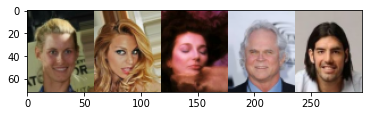

[[1 0 0 1]
 [1 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 1 0 1]]


In [28]:
plt.imshow(visual)
plt.show()
print(train_labels2[:5])

### Visualization 2

In [29]:
visual = train_images[:5].transpose((1, 0, 2, 3)).reshape(72, -1, 3)
print(visual.shape)

(72, 295, 3)


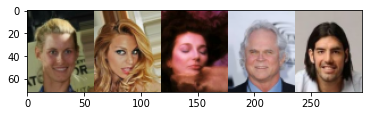

In [30]:
plt.imshow(visual)
plt.show()

### Modeling

##### 1. Two different model!
- model 1 for male/female classification
- model 2 for smiling/not smiling classification

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense

def simple_model():
    inputs = Input((72, 59, 3))

    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPool2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPool2D(2)(x)
    
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [32]:
# two models
gender_model = simple_model()
smile_model = simple_model()

In [33]:
gender_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 5, 64)          0     

In [34]:
gender_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
smile_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [35]:
gender_hist = gender_model.fit(train_images, train_male_labels, validation_data=(test_images, test_male_labels), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 5s 69ms/step - loss: 0.5957 - accuracy: 0.6890 - val_loss: 0.5689 - val_accuracy: 0.6800
Epoch 2/15
63/63 [==============================] - 4s 71ms/step - loss: 0.4579 - accuracy: 0.7965 - val_loss: 0.3710 - val_accuracy: 0.8400
Epoch 3/15
63/63 [==============================] - 4s 70ms/step - loss: 0.3353 - accuracy: 0.8565 - val_loss: 0.2593 - val_accuracy: 0.9000
Epoch 4/15
63/63 [==============================] - 4s 69ms/step - loss: 0.2314 - accuracy: 0.9115 - val_loss: 0.1966 - val_accuracy: 0.9200
Epoch 5/15
63/63 [==============================] - 4s 67ms/step - loss: 0.1728 - accuracy: 0.9340 - val_loss: 0.2020 - val_accuracy: 0.9250
Epoch 6/15
63/63 [==============================] - 4s 66ms/step - loss: 0.1250 - accuracy: 0.9585 - val_loss: 0.1581 - val_accuracy: 0.9350
Epoch 7/15
63/63 [==============================] - 4s 66ms/step - loss: 0.0946 - accuracy: 0.9670 - val_loss: 0.2335 - val_accuracy: 0.9250
Epoch 8/15
63

In [36]:
smile_hist = smile_model.fit(train_images, train_smile_labels, validation_data=(test_images, test_smile_labels), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 5s 69ms/step - loss: 0.6885 - accuracy: 0.5405 - val_loss: 0.6529 - val_accuracy: 0.6700
Epoch 2/15
63/63 [==============================] - 4s 67ms/step - loss: 0.6044 - accuracy: 0.6805 - val_loss: 0.5979 - val_accuracy: 0.7150
Epoch 3/15
63/63 [==============================] - 4s 67ms/step - loss: 0.4849 - accuracy: 0.7675 - val_loss: 0.4341 - val_accuracy: 0.7900
Epoch 4/15
63/63 [==============================] - 4s 65ms/step - loss: 0.3714 - accuracy: 0.8430 - val_loss: 0.3446 - val_accuracy: 0.8650
Epoch 5/15
63/63 [==============================] - 4s 64ms/step - loss: 0.3094 - accuracy: 0.8685 - val_loss: 0.3111 - val_accuracy: 0.8850
Epoch 6/15
63/63 [==============================] - 4s 64ms/step - loss: 0.2661 - accuracy: 0.8925 - val_loss: 0.3224 - val_accuracy: 0.8700
Epoch 7/15
63/63 [==============================] - 4s 64ms/step - loss: 0.2423 - accuracy: 0.9005 - val_loss: 0.3493 - val_accuracy: 0.8600
Epoch 8/15
63

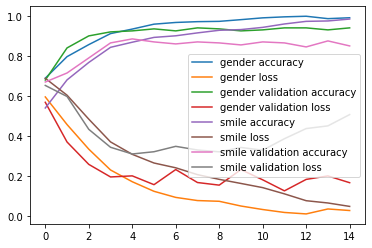

In [37]:
plt.plot(gender_hist.history['accuracy'], label = 'gender accuracy')
plt.plot(gender_hist.history['loss'], label = 'gender loss')
plt.plot(gender_hist.history['val_accuracy'], label = 'gender validation accuracy')
plt.plot(gender_hist.history['val_loss'], label = 'gender validation loss')

plt.plot(smile_hist.history['accuracy'], label = 'smile accuracy')
plt.plot(smile_hist.history['loss'], label = 'smile loss')
plt.plot(smile_hist.history['val_accuracy'], label = 'smile validation accuracy')
plt.plot(smile_hist.history['val_loss'], label = 'smile validation loss')

plt.legend()
plt.show()

### Model Test

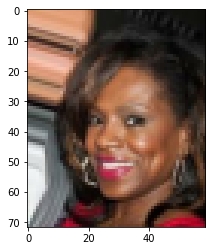

In [38]:
plt.imshow(test_images[1])

In [39]:
gender_res = gender_model.predict(test_images[1:2])

In [40]:
smile_res = smile_model.predict(test_images[1:2])

In [41]:
print(gender_res) # (0,1): male
print(smile_res) # (0,1):smiling

[[9.9999475e-01 5.2340633e-06]]
[[8.9374544e-07 9.9999917e-01]]


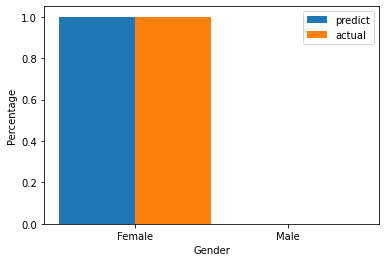

In [42]:
plt.bar(np.array(range(2))-0.25, gender_res[0], width=0.5, label="predict")
plt.bar(np.array(range(2))+0.25, test_male_labels[1], width=0.5, label="actual")
plt.xlabel("Gender")
plt.xticks(ticks=[0,1], labels=["Female", "Male"])
plt.ylabel("Percentage")
plt.legend()
plt.show()

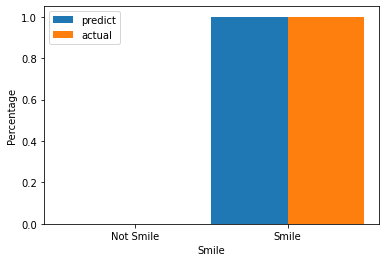

In [43]:
plt.bar(np.array(range(2))-0.25, smile_res[0], width=0.5, label="predict")
plt.bar(np.array(range(2))+0.25, test_smile_labels[1], width=0.5, label="actual")
plt.xlabel("Smile")
plt.xticks(ticks=[0,1], labels=["Not Smile", "Smile"])
plt.ylabel("Percentage")
plt.legend()
plt.show()

##### 2. Combine the Conv2D and MaxPooling part

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Flatten, Dense

def multi_model():
    inputs = Input((72, 59, 3))

    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPool2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPool2D(2)(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)

    gender_outputs = Dense(2, activation='softmax')(x)
    smile_outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs, [gender_outputs, smile_outputs])
    return model

In [45]:
mode = multi_model()

In [46]:
mode.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 70, 57, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 35, 28, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [47]:
mode.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [48]:
model_hist = mode.fit(train_images, [train_male_labels, train_smile_labels], validation_data=(test_images, [test_male_labels, test_smile_labels]), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 5s 70ms/step - loss: 1.2779 - dense_5_loss: 0.6014 - dense_6_loss: 0.6764 - dense_5_accuracy: 0.6735 - dense_6_accuracy: 0.5615 - val_loss: 1.1205 - val_dense_5_loss: 0.4920 - val_dense_6_loss: 0.6285 - val_dense_5_accuracy: 0.7750 - val_dense_6_accuracy: 0.6750
Epoch 2/15
63/63 [==============================] - 4s 70ms/step - loss: 1.0903 - dense_5_loss: 0.4733 - dense_6_loss: 0.6170 - dense_5_accuracy: 0.7795 - dense_6_accuracy: 0.6615 - val_loss: 1.0071 - val_dense_5_loss: 0.3816 - val_dense_6_loss: 0.6255 - val_dense_5_accuracy: 0.8500 - val_dense_6_accuracy: 0.6300
Epoch 3/15
63/63 [==============================] - 4s 67ms/step - loss: 0.8532 - dense_5_loss: 0.3542 - dense_6_loss: 0.4990 - dense_5_accuracy: 0.8510 - dense_6_accuracy: 0.7590 - val_loss: 0.7236 - val_dense_5_loss: 0.2887 - val_dense_6_loss: 0.4348 - val_dense_5_accuracy: 0.8750 - val_dense_6_accuracy: 0.8050
Epoch 4/15
63/63 [==============================] - 4s 

- dense_5_accuracy: 0.9965, dense_6_accuracy: 0.9810
- val_dense_5_accuracy: 0.9550, val_dense_6_accuracy: 0.8850

In [51]:
res = mode.predict(test_images[:1])

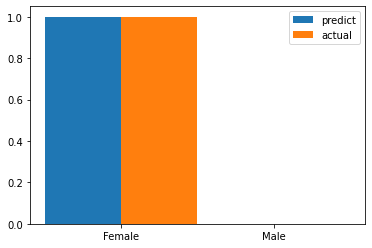

In [62]:
plt.bar(np.array(range(2))-0.25, res[0][0], width=0.5, label="predict")
plt.bar(np.array(range(2))+0.25, test_male_labels[0], width=0.5, label="actual")
plt.legend()
plt.xticks(ticks=[0,1], labels=['Female', 'Male'])
plt.show()

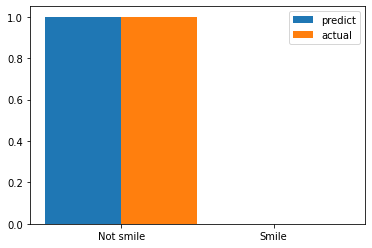

In [64]:
plt.bar(np.array(range(2))-0.25, res[1][0], width=0.5, label="predict")
plt.bar(np.array(range(2))+0.25, test_smile_labels[0], width=0.5, label="actual")
plt.legend()
plt.xticks(ticks=[0,1], labels=['Not smile', 'Smile'])
plt.show()

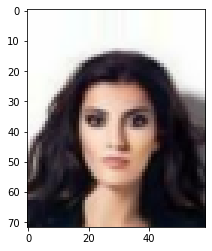

In [50]:
plt.imshow(test_images[0])

##### 2-1. Separate Model

In [65]:
mode.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 70, 57, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 35, 28, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [68]:
gender_model2 = Model(inputs=mode.inputs, outputs=mode.get_layer('dense_5').output)
smile_model2= Model(inputs=mode.inputs, outputs=mode.get_layer('dense_6').output)

In [69]:
gender_model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 5, 64)          0   

In [76]:
x = gender_model2.predict(test_images[:1])
print(x)

[[1.000000e+00 5.371226e-09]]


In [77]:
test_male_labels[0]

array([1, 0], dtype=int8)

In [78]:
x = smile_model2.predict(test_images[:1])
print(x)

[[9.9999905e-01 9.5724704e-07]]


In [79]:
test_smile_labels[0]

array([1, 0], dtype=int8)

### Save/Load Model

In [80]:
mode.save("./02.model")

INFO:tensorflow:Assets written to: ./02.model/assets


INFO:tensorflow:Assets written to: ./02.model/assets


In [81]:
!ls .

01.MNIST(RNN).ipynb    02.CelebaDataset.ipynb
01.models              02.model


In [82]:
test = tf.keras.models.load_model('./02.model')

In [83]:
test.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 70, 57, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 35, 28, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________